In [1]:
import importlib as imt 
import datasets_v0
import frame_xception_v1 as fr
imt.reload(datasets_v0)
imt.reload(fr)

import datetime as dt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import Model
import tensorflow.keras.backend as K

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error

import gc

In [2]:
#load datasets

In [2]:
X_train, X_test, y_train, y_test = datasets_v0.load_data()
y_train = tf.keras.utils.to_categorical(
    y_train, num_classes=6, dtype=np.uint8
)
y_test = tf.keras.utils.to_categorical(
    y_test, num_classes=6, dtype=np.uint8
)
frame = fr.framework_xception(batch_size=128)
input_size = (128,128,3)

get_metadata: Available Images: 29312


### BEGIN Autoencoder

In [11]:
autoencoder = tf.keras.models.load_model("../model/autoencoder_denoise_mse_0019.h5")
encoder = tf.keras.models.load_model("../model/encoder_denoise_mse_0019.h5")
decoder = tf.keras.models.load_model("../model/decoder_denoise_mse_0019.h5")

In [12]:
X_train_new = autoencoder.predict(X_train)
X_test_new = autoencoder.predict(X_test)

In [14]:
X_train.shape

(23449, 128, 128, 3)

In [15]:
# Prepare Datasets
frame.load_datagenerators(X_train_new, y_train, X_test_new, y_test, input_size = (128, 128))

### END AUTOENCODER

In [3]:
# Prepare Datasets
frame.load_datagenerators(X_train, y_train, X_test, y_test, input_size = (128, 128))

In [40]:
#reset datagen
frame.train_generator.reset()
frame.valid_generator.reset()
frame.test_generator.reset()

In [41]:
# load base model
base_model = Xception(weights='imagenet',
                      include_top=False,
                      input_shape=(128, 128, 3))

In [29]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [42]:
# load top model
top_model = base_model.output
top_model = Flatten()(top_model)
top_model = Dense(2048, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(1024, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
predictions = Dense(6, activation='softmax')(top_model)

In [43]:
# stack
model = Model(inputs= base_model.input, outputs= predictions)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [44]:
fr.print_model_properties(model)

Layer 0 | Name: input_3 | Trainable: True
Layer 1 | Name: block1_conv1 | Trainable: True
Layer 2 | Name: block1_conv1_bn | Trainable: True
Layer 3 | Name: block1_conv1_act | Trainable: True
Layer 4 | Name: block1_conv2 | Trainable: True
Layer 5 | Name: block1_conv2_bn | Trainable: True
Layer 6 | Name: block1_conv2_act | Trainable: True
Layer 7 | Name: block2_sepconv1 | Trainable: True
Layer 8 | Name: block2_sepconv1_bn | Trainable: True
Layer 9 | Name: block2_sepconv2_act | Trainable: True
Layer 10 | Name: block2_sepconv2 | Trainable: True
Layer 11 | Name: block2_sepconv2_bn | Trainable: True
Layer 12 | Name: conv2d_8 | Trainable: True
Layer 13 | Name: block2_pool | Trainable: True
Layer 14 | Name: batch_normalization_8 | Trainable: True
Layer 15 | Name: add_24 | Trainable: True
Layer 16 | Name: block3_sepconv1_act | Trainable: True
Layer 17 | Name: block3_sepconv1 | Trainable: True
Layer 18 | Name: block3_sepconv1_bn | Trainable: True
Layer 19 | Name: block3_sepconv2_act | Trainable: 

In [45]:
# set trainable layer to top layers only
fr.change_trainable_layers(model, 129)

In [46]:
optimizer = optimizers.Adam(
    learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
    )
#optimizer = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)

In [47]:
import tensorflow.keras.backend as K
def soft_rmse(y_true, y_pred):
    return K.sqrt(  K.mean(K.cast_to_floatx ( K.square( K.argmax(y_true) - K.argmax(y_pred) )), axis=-1) ) 
y_true = [[0,0,0,1,0,0], [0,0,0,1,0,0], [0,0,1,0,0,0]]
y_pred = [[0,0,1,0,0,0], [0,0,1,0,0,0], [0,0,0,0,1,0]]
score = soft_rmse(y_true, y_pred)

In [48]:
# model.compile(loss='mean_squared_error',
#                     optimizer=optimizer,
#                     metrics=[fr.soft_acc, tf.keras.metrics.RootMeanSquaredError()])
model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy', soft_rmse])

In [49]:
print('\nFitting the model ... ...')
log_dir="../logs/xception/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0.0001)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(
        x=frame.train_generator,
        #y=self.train_df['label'].values,
        #generator = train_generator,
        batch_size=None,
        epochs=50,
        verbose=1,
        validation_data=frame.valid_generator,
        #shuffle=False,
        #class_weight=None,
        #sample_weight=None,
        #initial_epoch=0,
        steps_per_epoch=frame.STEP_SIZE_TRAIN,
        validation_steps=frame.STEP_SIZE_VALID,
        #validation_freq=1,
        max_queue_size=frame.batch_size*8,
        #workers=4,
        use_multiprocessing=False,
        callbacks=[tensorboard_callback]
    )


Fitting the model ... ...
Train for 146 steps, validate for 36 steps
Epoch 1/50
146/146 [==============================] - 124s 852ms/step - loss: 2.0395 - accuracy: 0.2175 - soft_rmse: 2.0655 - val_loss: 1.7951 - val_accuracy: 0.1712 - val_soft_rmse: 2.9078
Epoch 2/50
146/146 [==============================] - 120s 822ms/step - loss: 1.6427 - accuracy: 0.2731 - soft_rmse: 1.8797 - val_loss: 1.8480 - val_accuracy: 0.1799 - val_soft_rmse: 2.2864
Epoch 3/50
146/146 [==============================] - 119s 817ms/step - loss: 1.5669 - accuracy: 0.3004 - soft_rmse: 1.7834 - val_loss: 1.8430 - val_accuracy: 0.1723 - val_soft_rmse: 2.1180
Epoch 4/50
146/146 [==============================] - 119s 815ms/step - loss: 1.4788 - accuracy: 0.3470 - soft_rmse: 1.6691 - val_loss: 1.8139 - val_accuracy: 0.1712 - val_soft_rmse: 2.9078
Epoch 5/50
146/146 [==============================] - 121s 826ms/step - loss: 1.3676 - accuracy: 0.3987 - soft_rmse: 1.5560 - val_loss: 2.0663 - val_accuracy: 0.1712 - va

KeyboardInterrupt: 

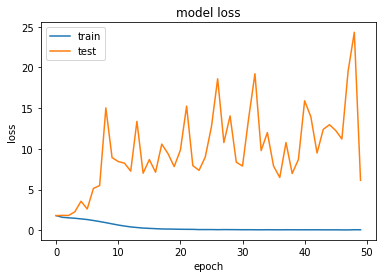

In [38]:
import matplotlib.pyplot as plt

def plot_history(history):    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
plot_history(history)

In [39]:
print('\nValidationg the model ... ...')
log_dir="../logs/validation/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.evaluate(
        x=frame.test_generator,
        y=None,
        batch_size=None,
        verbose=1,
        sample_weight=None,
        steps=frame.STEP_SIZE_TEST,
        max_queue_size=frame.batch_size*8,
        #workers=1,
        use_multiprocessing=False,
        callbacks=[tensorboard_callback]
    )


Validationg the model ... ...
45/45 [==============================] - 24s 532ms/step - loss: 6.1136 - accuracy: 0.1688 - soft_rmse: 2.8971


[6.113634904225667, 0.16875, 2.8971438]

In [18]:
pred = model.predict(x=frame.test_generator,
            steps=frame.STEP_SIZE_TEST,
            max_queue_size=frame.batch_size*8,
            #workers=8,
            use_multiprocessing=False,
            verbose=True)

45/45 [==============================] - 24s 537ms/step


In [54]:
tf.__version__

'2.0.0'

In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [18]:
import gc

In [19]:
gc.collect()

34

In [2]:
import tensorflow as tf
tf.debugging.set_log_device_placement(False)